In [1]:
%matplotlib inline

from collections import Counter
from ydata_profiling import ProfileReport
import glob
import os
import re
import random
import matplotlib.pyplot as plt
from pathlib import Path as path
import numpy as np
import pandas as pd
import seaborn as sns
#from pandas_profiling import ProfileReport
import ydata_profiling
from imblearn.over_sampling import SMOTE
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    precision_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path

In [2]:
#les chemins d'accès aux fichiers
root_file="C:/Users/14387"

os.chdir(root_file)
actual_dir=Path.cwd()

project_repo = actual_dir/"Apache_Hive_Bug_Prediction_ML_/"
#hive_repo = project_repo.parent/"Apache_Hive/"
#os.chdir(hive_repo)
#project_repo = path("/home/nicolas-richard/Desktop/.Apache_Hive_Bug_Prediction_ML_Model")

In [3]:
def extract_version(filename):
    file_part = filename.split('/')[-1]

    parts = file_part.split('-')
    if len(parts) < 2:
        raise ValueError("Filename does not contain a version segment.")

    version_part = parts[1].split('_')[0]
    return version_part

In [4]:
input_files = glob.glob(os.path.join(project_repo, 'UND_hive_updated_data_model2', '*.csv'))

concatenated_df = pd.DataFrame()

for file in input_files:
    print(file)
    df = pd.read_csv(file)
    
    version = extract_version(file)
    df.insert(loc=2, column='Version', value=version)
    concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)

concatenated_df.info()
count = concatenated_df['Version'].nunique()

C:\Users\14387\Apache_Hive_Bug_Prediction_ML_\UND_hive_updated_data_model2\UND_hive-2.0.0_processed.csv
C:\Users\14387\Apache_Hive_Bug_Prediction_ML_\UND_hive_updated_data_model2\UND_hive-2.0.1_processed.csv
C:\Users\14387\Apache_Hive_Bug_Prediction_ML_\UND_hive_updated_data_model2\UND_hive-2.1.0_processed.csv
C:\Users\14387\Apache_Hive_Bug_Prediction_ML_\UND_hive_updated_data_model2\UND_hive-2.1.1_processed.csv
C:\Users\14387\Apache_Hive_Bug_Prediction_ML_\UND_hive_updated_data_model2\UND_hive-2.2.0_processed.csv
C:\Users\14387\Apache_Hive_Bug_Prediction_ML_\UND_hive_updated_data_model2\UND_hive-2.3.0_processed.csv
C:\Users\14387\Apache_Hive_Bug_Prediction_ML_\UND_hive_updated_data_model2\UND_hive-2.3.10_processed.csv
C:\Users\14387\Apache_Hive_Bug_Prediction_ML_\UND_hive_updated_data_model2\UND_hive-2.3.1_processed.csv
C:\Users\14387\Apache_Hive_Bug_Prediction_ML_\UND_hive_updated_data_model2\UND_hive-2.3.2_processed.csv
C:\Users\14387\Apache_Hive_Bug_Prediction_ML_\UND_hive_updated_

In [5]:
concatenated_df.drop_duplicates
data = concatenated_df.iloc[:,[0,7,8,9,11,3,4,5,6,20,21,22,27,28,29,33,36,38,39,
                               40,42,43,44,45,46,47,53,54,55,57,64,65,66,75,76,
                               77,78,80,16,17,19,70,73,82,83,84,85,86,87,88,89,
                               90,91,92,93,100,101,102,103,104,105,106,107,108,109,110,111,112]]
data.dropna(inplace=True)
data = data.reset_index(drop=True)
data.info()

X = data.drop('Bug', axis=1)
y = data['Bug']

print("Class Distribution:")
print(y.value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140617 entries, 0 to 140616
Data columns (total 68 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Bug                        140617 non-null  int64  
 1   AvgCyclomatic              140617 non-null  float64
 2   AvgCyclomaticModified      140617 non-null  float64
 3   AvgCyclomaticStrict        140617 non-null  float64
 4   AvgEssential               140617 non-null  float64
 5   AvgCountLine               140617 non-null  float64
 6   AvgCountLineBlank          140617 non-null  float64
 7   AvgCountLineCode           140617 non-null  float64
 8   AvgCountLineComment        140617 non-null  float64
 9   CountDeclClass             140617 non-null  float64
 10  CountDeclClassMethod       140617 non-null  float64
 11  CountDeclClassVariable     140617 non-null  float64
 12  CountDeclFunction          140617 non-null  float64
 13  CountDeclInstanceMethod    14

C:\Users\14387\AppData\Local\Temp\ipykernel_11776\3361925918.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [6]:
numeric_features = data.select_dtypes(include=['float64']).columns.tolist()
print(numeric_features)
def remove_outliers(df, numeric_cols, std_threshold=3):
    df_clean = data.copy()
    
    for col in numeric_cols:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        df_clean = df_clean[abs(df_clean[col] - mean) <= std_threshold * std]
    
    return df_clean

data_no_outliers = remove_outliers(data, numeric_features)

['AvgCyclomatic', 'AvgCyclomaticModified', 'AvgCyclomaticStrict', 'AvgEssential', 'AvgCountLine', 'AvgCountLineBlank', 'AvgCountLineCode', 'AvgCountLineComment', 'CountDeclClass', 'CountDeclClassMethod', 'CountDeclClassVariable', 'CountDeclFunction', 'CountDeclInstanceMethod', 'CountDeclInstanceVariable', 'CountDeclMethod', 'CountDeclMethodDefault', 'CountDeclMethodPrivate', 'CountDeclMethodProtected', 'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode', 'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment', 'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe', 'MaxCyclomatic', 'MaxCyclomaticModified', 'MaxCyclomaticStrict', 'RatioCommentToCode', 'SumCyclomatic', 'SumCyclomaticModified', 'SumCyclomaticStrict', 'SumEssential', 'CountClassBase', 'CountClassCoupled', 'CountClassDerived', 'MaxInheritanceTree', 'PercentLackOfCohesion', 'CountInputMin', 'CountInputMean', 'CountInputMax', 'CountOutputMin', 'CountOutputMean', 'CountOutputMax', 'CountPathMin'

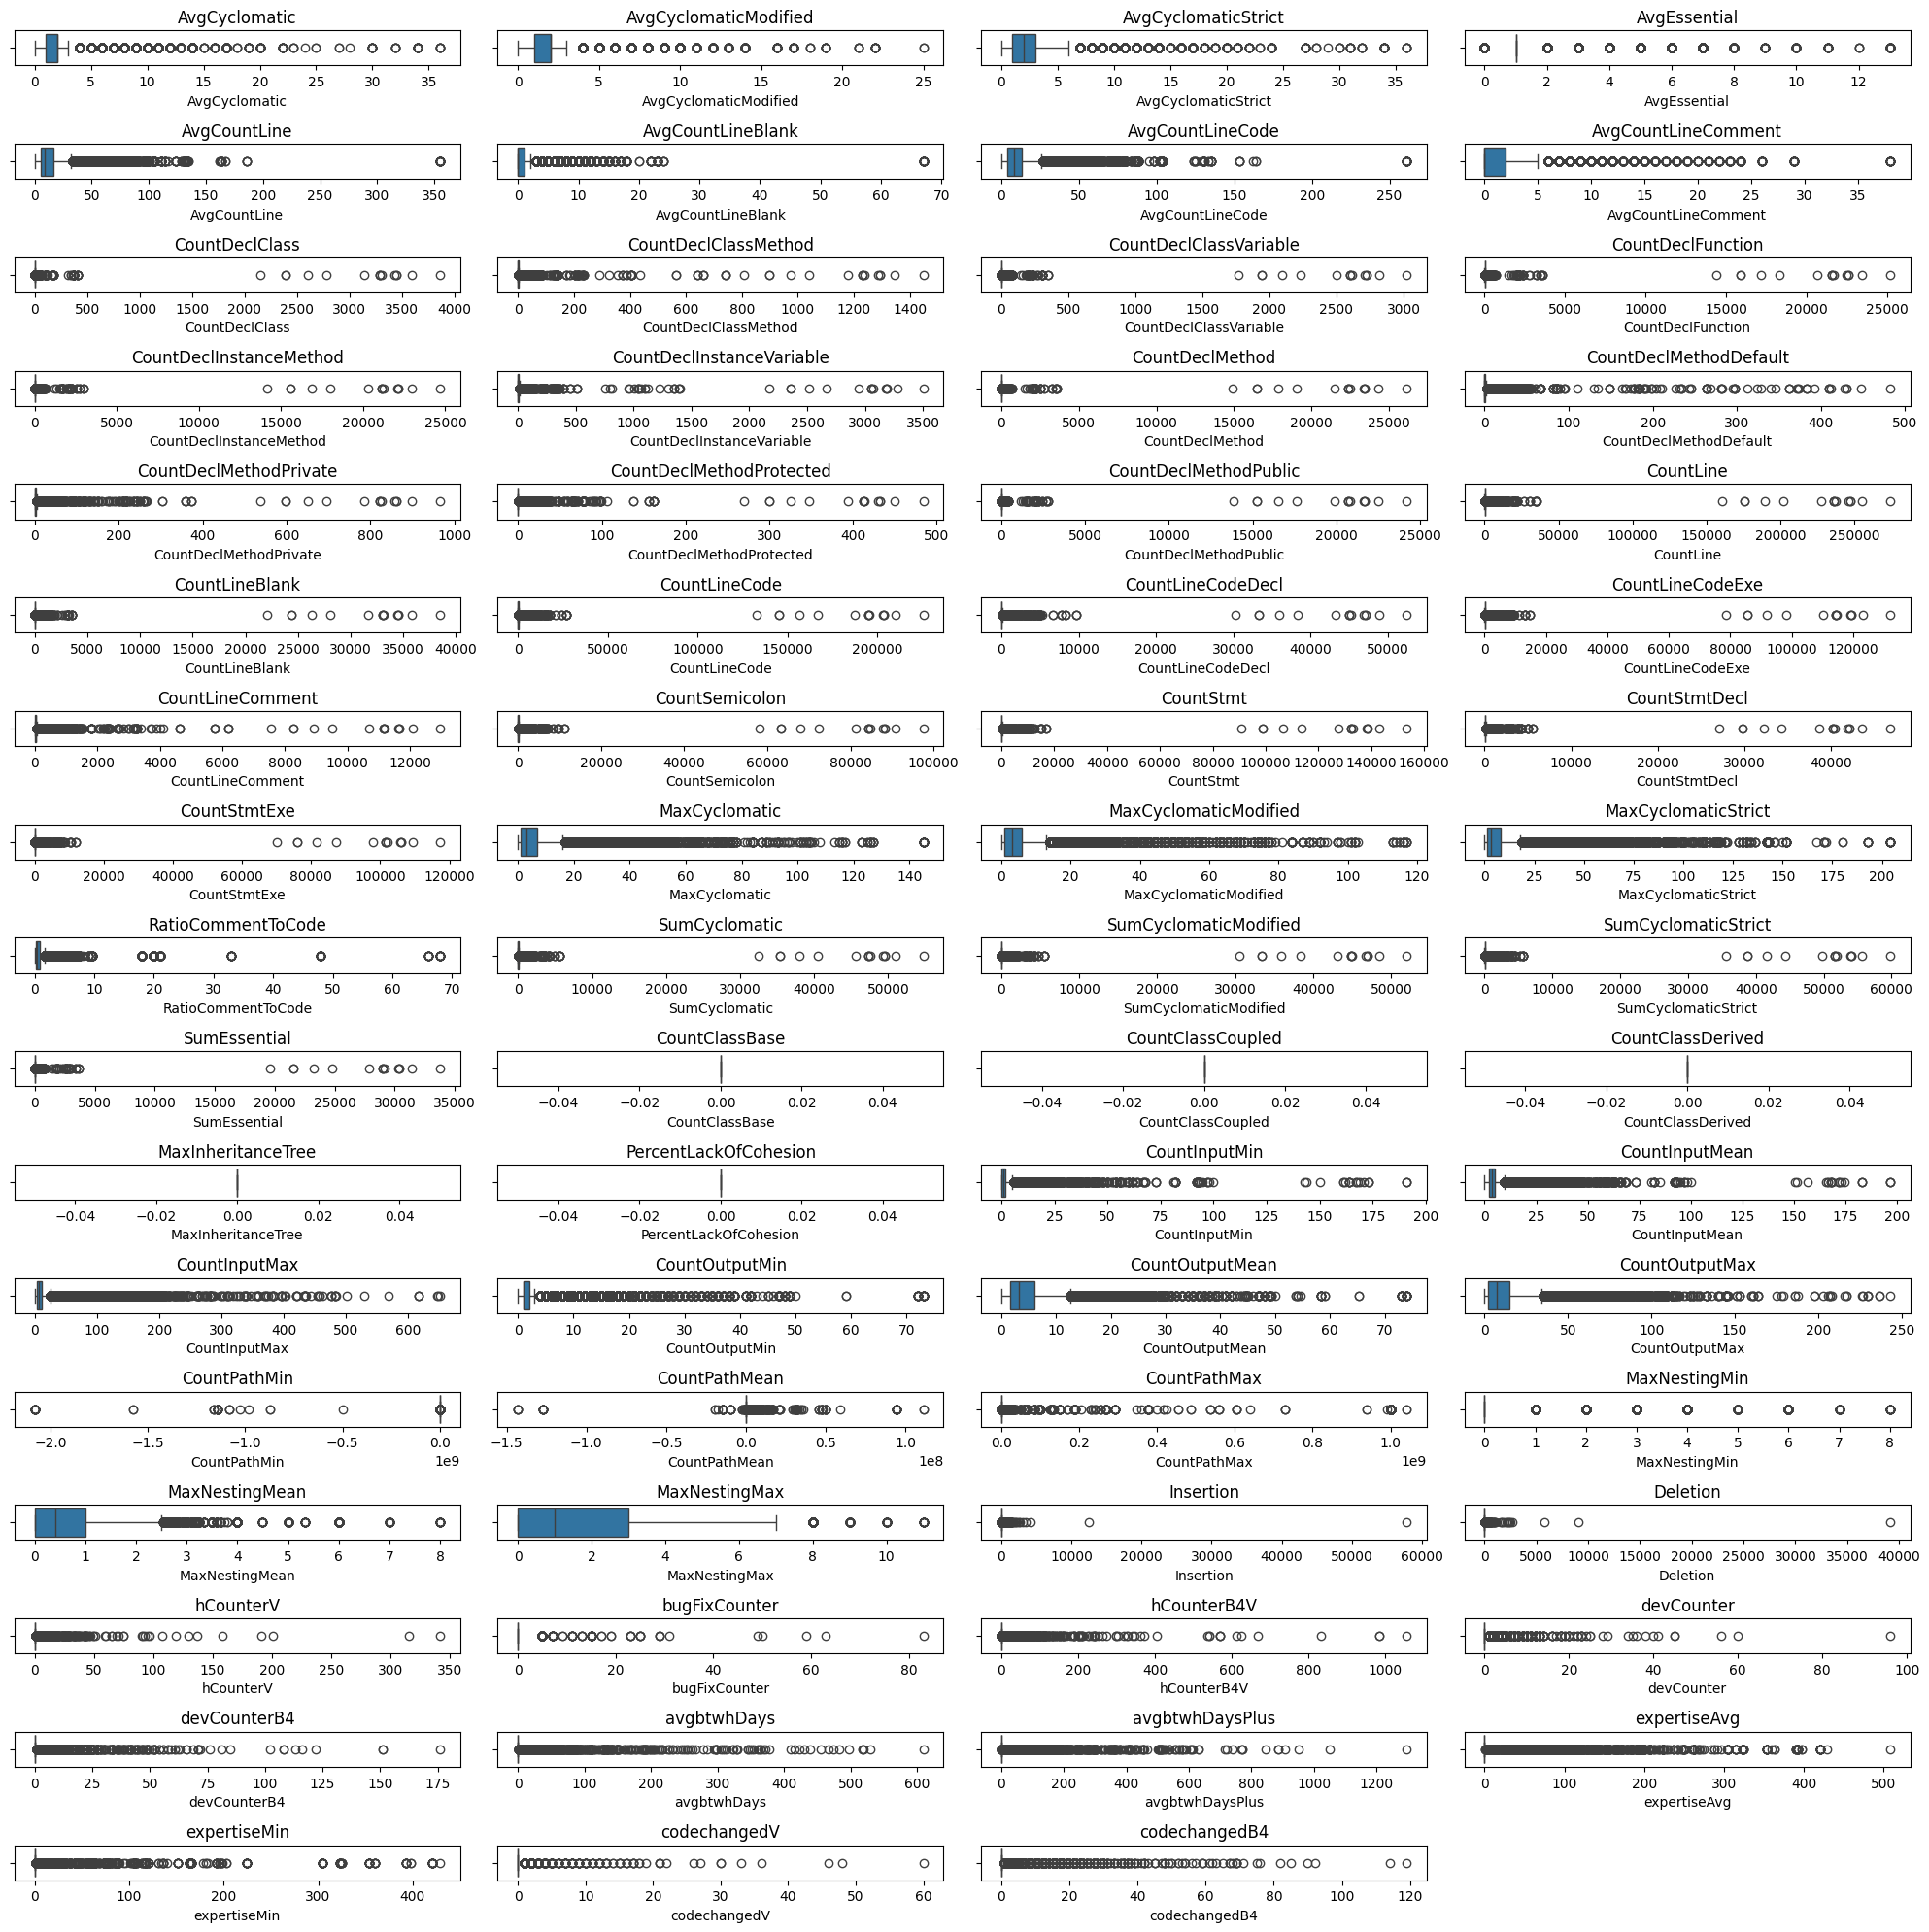

In [7]:
plt.figure(figsize=(20, 20))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(17, 4, i)
    sns.boxplot(x=data[feature])
    plt.title(f'{feature}')
plt.tight_layout()
plt.show()

In [8]:
X = data.drop('Bug', axis=1)
y = data['Bug']

X_no_outliers = data_no_outliers.drop('Bug', axis=1)
y_no_outliers = data_no_outliers['Bug']


print("Class distribution for data with outliers :")
print(y.value_counts())
print("Class distribution for data without outliers :")
print(y_no_outliers.value_counts())

Class distribution for data with outliers :
Bug
0    137670
1      2947
Name: count, dtype: int64
Class distribution for data without outliers :
Bug
0    63600
1       49
Name: count, dtype: int64


In [9]:
def drop_highly_correlated_features(X, threshold=0.9):

    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    X_reduced = X.drop(columns=to_drop)
    
    return X_reduced, to_drop

X, dropped_features = drop_highly_correlated_features(X, threshold=0.85)

print(f"Dropped {len(dropped_features)} features due to high correlation:")
print(dropped_features)

Dropped 30 features due to high correlation:
['AvgCyclomaticModified', 'AvgCyclomaticStrict', 'AvgCountLineCode', 'CountDeclClassVariable', 'CountDeclFunction', 'CountDeclInstanceMethod', 'CountDeclInstanceVariable', 'CountDeclMethod', 'CountDeclMethodProtected', 'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode', 'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment', 'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe', 'MaxCyclomaticModified', 'MaxCyclomaticStrict', 'SumCyclomatic', 'SumCyclomaticModified', 'SumCyclomaticStrict', 'SumEssential', 'Deletion', 'devCounter', 'devCounterB4', 'expertiseMin']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,            
    random_state=42       
)

In [11]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

smote_data = pd.concat([pd.DataFrame(X_smote), pd.Series(y_smote)], axis=1)

majority_class = smote_data[smote_data.iloc[:, -1] == 0]
minority_class = smote_data[smote_data.iloc[:, -1] == 1]

majority_downsampled = resample(majority_class,
                                replace=False, 
                                n_samples=len(minority_class),  
                                random_state=42)

balanced_data = pd.concat([majority_downsampled, minority_class])

X_train_resampled = balanced_data.iloc[:, :-1]
y_train_resampled = balanced_data.iloc[:, -1]

print(Counter(y_train_resampled))

C:\Users\14387\anaconda3\envs\MasterSoftwareEngineering\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\14387\anaconda3\envs\MasterSoftwareEngineering\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Counter({0: 103252, 1: 103252})


In [12]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_resampled
)

class_weight_custom = {0: class_weights[0], 1: class_weights[1]}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

thresholds = np.arange(0.500000, 0.999999, 0.00001).tolist()

2. Modelo de Regression lineal

In [13]:
log_reg = LogisticRegression(
    solver='sag',         
    penalty='l2',          
    max_iter=1000000,         
    n_jobs=-1,             
    random_state=42,
    tol=1e-6,
    class_weight=class_weight_custom    
)

log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('Logistic_Regression', log_reg)
])

In [14]:
log_reg_pipeline.fit(X_train_resampled, y_train_resampled)

y_pred_proba_log_reg = log_reg_pipeline.predict_proba(X_test)[:, 1]

best_threshold = 0.5
best_precision = 0

for threshold in thresholds:
    y_pred_custom = (y_pred_proba_log_reg >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_custom)

    if precision > best_precision: 
        best_threshold = threshold
        best_precision = precision  

y_pred_log_reg = (y_pred_proba_log_reg >= best_threshold).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

print(f'Best Threshold: {best_threshold:.2f}')
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
print(f'AUC Score - Logistic Regression: {roc_auc_log_reg:.2f}')

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log_reg)


Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34418
           1       1.00      0.90      0.95       737

    accuracy                           1.00     35155
   macro avg       1.00      0.95      0.97     35155
weighted avg       1.00      1.00      1.00     35155

Best Threshold: 0.73
AUC Score - Logistic Regression: 0.97


In [15]:
random_forest = RandomForestClassifier(
    n_estimators=10000,
    max_depth=100,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    class_weight=class_weight_custom
)
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('random forest', random_forest)
])

In [16]:
rf_pipeline.fit(X_train_resampled, y_train_resampled)

y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

best_threshold = 0.5
best_precision = 0

for threshold in thresholds:
    y_pred_custom = (y_pred_proba_rf >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_custom)
    #print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}")

    if precision > best_precision: 
        best_threshold = threshold
        best_precision = precision  

y_pred_rf = (y_pred_proba_log_reg >= best_threshold).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_rf))

print(f'Best Threshold: {best_threshold}')
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f'AUC Score - Random Forest: {roc_auc_rf:.4f}')


fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)


Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34418
           1       1.00      0.87      0.93       737

    accuracy                           1.00     35155
   macro avg       1.00      0.94      0.97     35155
weighted avg       1.00      1.00      1.00     35155

Best Threshold: 0.9999099999977249
AUC Score - Random Forest: 0.9795


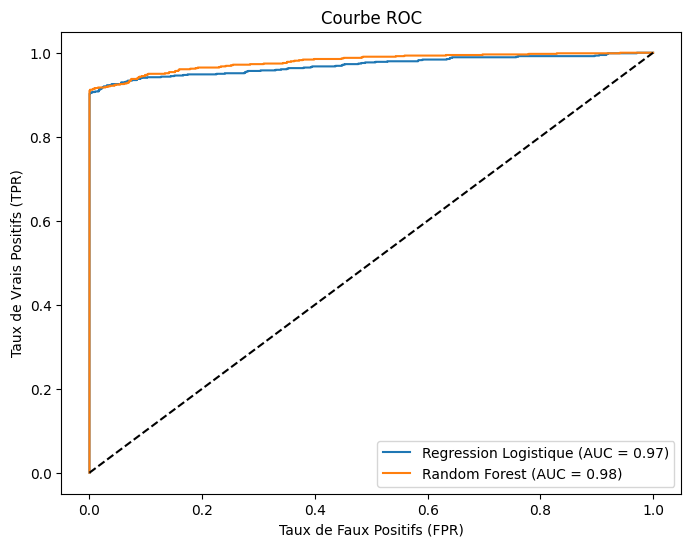

In [17]:
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Regression Logistique (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()